imports

In [1]:
import torch
import os
from tqdm.notebook import tqdm as tqdm
import pandas as pd
import json
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import hashlib

import warnings
import sys
warnings.filterwarnings("ignore")
sys.path.insert(1, '../train')
sys.path.insert(1, '../misc')

import config_plots, TrialStatistics
from configParser import getModelName, ConfigParser
import CNN

config_plots.global_settings()

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/official_experiments/" # Where experiment results will be produced
dataPath="/raid/elhamod/Fish" # Where data is

experiment_list = [
    {
       'experimentName': "Hard",
       'experimentHash': None
    },
    {
       'experimentName': "Easy",
       'experimentHash': None
    },
]

# The subpath where the figure will be saved.
figures_subpath = 'pretraining_BBvsHGNN'

figsize=(24, 10)
ylabel = "accuracy (f1-score)"
xlabel = "model"
xticks = [3]
xticklabels = [""] 


cuda=0

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 0


Create aggregate dataframe

In [4]:
full_df = pd.DataFrame()

for entry in experiment_list:
    experimentName = entry["experimentName"]
    experimentHashes = entry["experimentHash"]

    config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

    df_path = os.path.join(experimentsPath, experimentName, "results", "raw_experiments.csv")
    df = pd.read_csv(df_path)

    paramsIterator = config_parser.getExperiments()  
    number_of_experiments = sum(1 for e in paramsIterator)  

    for experiment_params in config_parser.getExperiments():

        # get data frame
        experimentHash_ = TrialStatistics.getTrialName(experiment_params)
        if (experimentHashes is None) or (experimentHash_ in experimentHashes):
            df_rows = df[df['experimentHash'] == experimentHash_]
            full_df = pd.concat([full_df, df_rows])

Show dataframe

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
full_df = full_df.replace('/','', regex=True).replace('_','', regex=True)
full_df

,Unnamed: 0,image_path,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,tl_model,link_layer,adaptive_smoothing,adaptive_lambda,adaptive_alpha,pretrained,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,0,Hardcurated3050,448,True,64,0.0001,5,1,HGNN,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.088941,0.548886,0.791798,0.831618,0.785908,10067.837873,43.0,91.908714,93.672200,9f2ee487f1a968c58edd8935acf51e063c97d95e4f4e37...,0,382868e548a7caf52a35dd090fedf67cbcabaf182ee943...
1,1,Hardcurated3050,448,True,64,0.0001,5,1,HGNN,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.075023,0.562886,0.805718,0.862167,0.785432,11247.326665,48.0,92.323654,94.294610,9f2ee487f1a968c58edd8935acf51e063c97d95e4f4e37...,1,aa0326fcda24d700b9d3f73749abd1144ada48b42f1923...
2,2,Hardcurated3050,448,True,64,0.0001,5,1,HGNN,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.089332,0.548400,0.807645,0.822711,0.774023,9640.570944,41.0,92.323654,94.709540,9f2ee487f1a968c58edd8935acf51e063c97d95e4f4e37...,2,fa30899284f1950bf87b8124d83121fc6035798fcfaf30...
3,3,Hardcurated3050,448,True,64,0.0001,5,1,HGNN,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.082215,0.555531,0.796460,0.841695,0.777996,7288.963918,31.0,91.597510,93.361000,9f2ee487f1a968c58edd8935acf51e063c97d95e4f4e37...,3,8342264f39f1d26ae93975dc73e92db44184fc5d1182c7...
4,4,Hardcurated3050,448,True,64,0.0001,5,1,HGNN,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.082131,0.555699,0.799215,0.889284,0.784860,13939.373428,60.0,92.116180,94.813280,9f2ee487f1a968c58edd8935acf51e063c97d95e4f4e37...,4,585c6c93fee9fc2815ef10db6fb05e1fe51bbebd22a28d...
5,5,Hardcurated3050,448,True,64,0.0001,5,1,BB,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.080575,0.557324,0.793528,0.428191,0.773666,14007.912337,62.0,91.182570,93.568470,1c8073ef9d58167544640df071192688d86e4546a1161b...,0,3e3ce20559ffb11cf290b7938361bfc31904cbd4aa48b3...
6,6,Hardcurated3050,448,True,64,0.0001,5,1,BB,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.082521,0.555336,0.795717,0.664193,0.772231,13577.068654,60.0,92.531120,93.568470,1c8073ef9d58167544640df071192688d86e4546a1161b...,1,0f89fa65a7978b65bf2f55c1adb0b7a4c0024ae05f1653...
7,7,Hardcurated3050,448,True,64,0.0001,5,1,BB,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.097168,0.540539,0.771129,0.508782,0.784039,9538.856757,42.0,90.560165,93.153530,1c8073ef9d58167544640df071192688d86e4546a1161b...,2,6d658efb0b3ef54631538895ec66659132cb12a737950b...
8,8,Hardcurated3050,448,True,64,0.0001,5,1,BB,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.064231,0.573743,0.815672,0.717875,0.787551,17400.565676,77.0,93.568470,94.605810,1c8073ef9d58167544640df071192688d86e4546a1161b...,3,1b36e30495ed896425429fa706f39943ae8eee6244a049...
9,9,Hardcurated3050,448,True,64,0.0001,5,1,BB,0.01,ResNet18,avgpool,True,0.01,0.9,True,4.100450,0.537242,0.782036,0.499086,0.773501,9626.495421,43.0,91.078840,93.361000,1c8073ef9d58167544640df071192688d86e4546a1161b...,4,6690cf34f36d50751330ff7cfce45155615e0a5f5dbd48...


dataframe extracts

In [7]:
# Make any extracts of edits necessary to the dataframe
displays = [
    {
        'df': full_df[(full_df['modelType'] == 'BB')] ,
        'columns': ['macro f1 test fine'],
        'bys': ['image_path'],
        'positions': [-0.2, 0.8, 1.8],
        'color': 'g',
        'legend': "$\mathbf{Blackbox}$"
    },
    {
        'df': full_df[(full_df['modelType'] == 'HGNN')],
        'columns': ['macro f1 test fine'],
        'bys': ['image_path'],
        'positions': [0.2, 1.2, 2.2],
        'color': 'r',
        'legend': "$\mathbf{HGNN}$"
    },
]

Prepare and plot

In [8]:
fig,ax = plt.subplots(figsize=figsize)
plt.close()

def plot_boxplot(df, fig, ax, columns, bys, color, positions):
    ax.set_xticks(range(len(df)))
    TrialStatistics.pandasBoxplot(df, columns, bys, ax, color, positions)

In [9]:
for display in displays:
    plot_boxplot(display['df'], fig, ax, 
                 display['columns'], display['bys'], display['color'], 
                 display['positions'])

patches=[]
for display in displays:
    patches.append(mpatches.Patch(color=display['color'], label=display['legend']))
ax.legend(handles=patches)

<Figure size 2700x1500 with 0 Axes>

In [10]:
ax.set_title("")
fig.suptitle("")
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

[Text(0, 0, '')]

In [11]:
name = "boxplot - " +  hashlib.sha224(str([full_df, displays]).encode('utf-8')).hexdigest()

dir_ = os.path.join(experimentsPath, 'figures', figures_subpath)    

if not os.path.exists(dir_):
    os.makedirs(dir_)
fig.savefig(os.path.join(dir_,name+ ".pdf"), bbox_inches='tight')

with open(os.path.join(dir_, 'experiments.json'), 'w') as f:
    json.dump(experiment_list, f)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


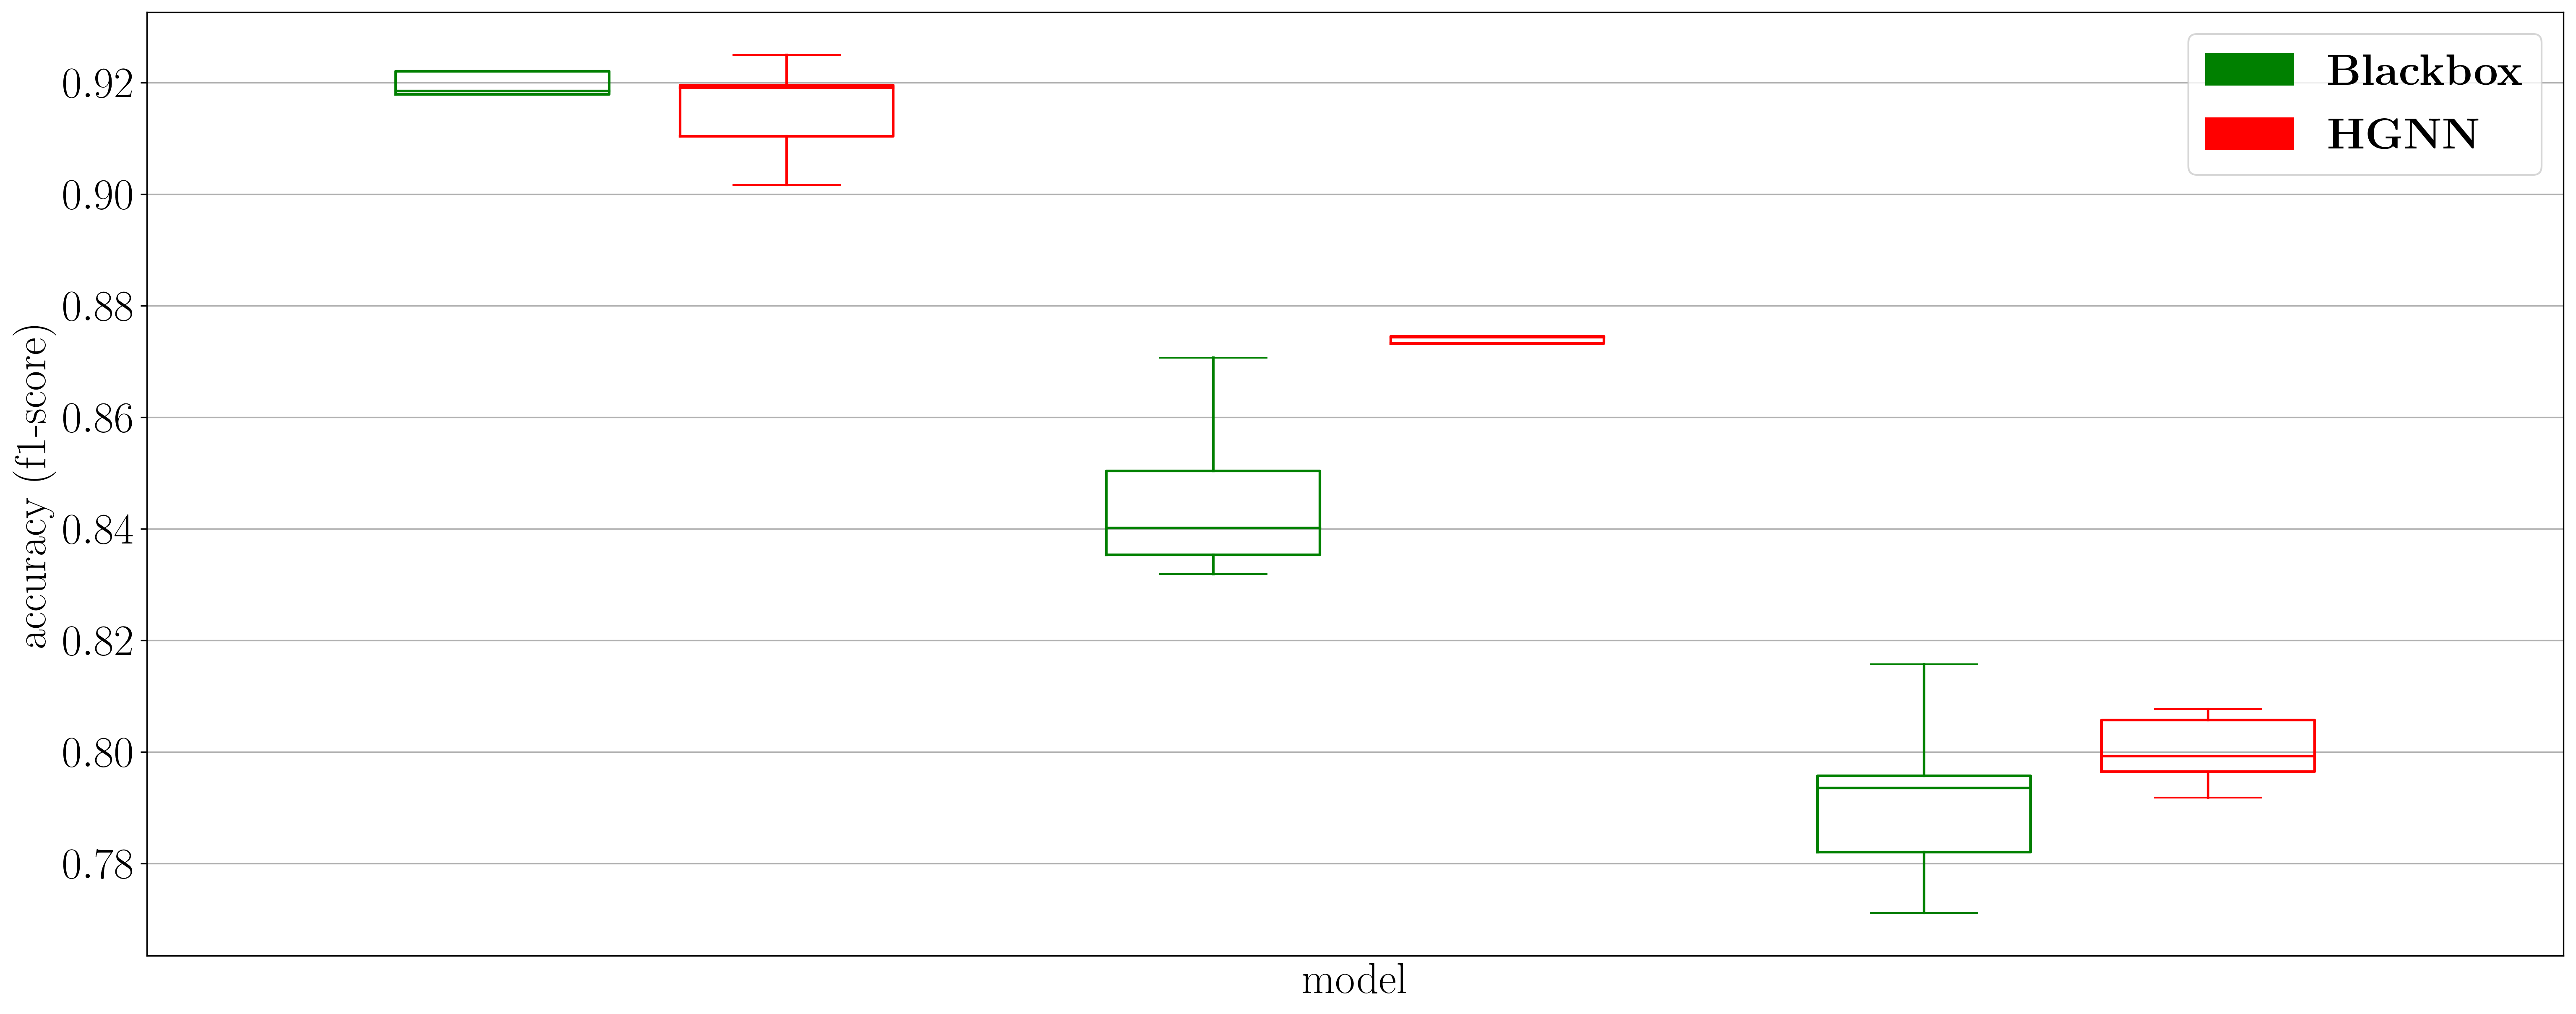

In [12]:
fig